<a href="https://colab.research.google.com/github/MdAashif-h/Edunet_Internship-AIML-/blob/main/EdunetAiml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

# Add missing imports
from pathlib import Path
import os

# Consistent paths for ALL days
DATASET_DIR = "/content/drive/MyDrive/Crop_Disease_Project/plantvillage"
MODEL_DIR = "/content/drive/MyDrive/Crop_Disease_Project/models"
KAGGLE_DIR = "/content/drive/MyDrive/kaggle"

TRAIN_DIR = Path(f"{DATASET_DIR}/train")
VAL_DIR = Path(f"{DATASET_DIR}/val")
MODEL_PATH = f"{MODEL_DIR}/final_crop_disease_model.h5"
CLASS_INDICES_PATH = f"{MODEL_DIR}/class_indices.npy"

# Create directories
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
# Note: train/val folders will be created later during dataset splitting

Mounted at /content/drive


In [ ]:
# ===============================================================
# AI-BASED CROP DISEASE DETECTION PROJECT
# Day 1: Final (Production-quality) Setup, Download, Auto-Split & EDA
# ===============================================================

# Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

print("="*70)
print("AI-BASED CROP DISEASE DETECTION - DAY 1 (FINAL)")
print("="*70)

# -------------------------
# STEP 0: Config & Path Setup
# -------------------------
DOWNLOAD_DATASET = True                 # set False if dataset already downloaded
DATASET_REF = "abdallahalidev/plantvillage-dataset"
ZIP_NAME = "/content/drive/MyDrive/Crop_Disease_Project/plantvillage-dataset.zip"
EXTRACT_PATH = Path("/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw")
TRAIN_DIR = Path("/content/drive/MyDrive/Crop_Disease_Project/plantvillage/train")
VAL_DIR = Path("/content/drive/MyDrive/Crop_Disease_Project/plantvillage/val")
KAGGLE_JSON_PATH = "/content/drive/MyDrive/kaggle/kaggle.json"
MIN_IMAGES_PER_CLASS = 5               # skip classes with fewer images
RESIZE_ON_COPY = True                  # set False to keep original size
RESIZE_WH = (256, 256)                 # resize target (HxW)
VALID_EXT = {'.jpg', '.jpeg', '.png', '.bmp'}

# Create base directories
os.makedirs("/content/drive/MyDrive/Crop_Disease_Project", exist_ok=True)

# -------------------------
# STEP 1: GPU check
# -------------------------
print("\n STEP 1: Checking GPU availability...")
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("TensorFlow:", tf.__version__)
print("GPUs found:", gpus)
if gpus:
    print("GPU detected - enabling memory growth")
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass
else:
    print("No GPU detected. For faster training enable GPU in Colab: Runtime -> Change runtime type -> GPU")

# -------------------------
# STEP 2: Install libs
# -------------------------
print("\n STEP 2: Installing required libraries...")
!pip install -q kaggle plotly seaborn pillow tqdm
print("Install step done")

# -------------------------
# STEP 3: imports
# -------------------------
print("\n STEP 3: Importing libraries...")
import zipfile, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
print("Imports ready")

# -------------------------
# STEP 4: Kaggle API setup (use existing Drive file)
# -------------------------
print("\n STEP 4: Kaggle API setup")
if not os.path.exists(KAGGLE_JSON_PATH):
    raise FileNotFoundError(f"kaggle.json not found at {KAGGLE_JSON_PATH}")

# Copy from Drive to ~/.kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy2(KAGGLE_JSON_PATH, os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
print("kaggle.json loaded from Drive")

# Verify
print("kaggle CLI version:")
!kaggle --version

# -------------------------
# STEP 5: Download dataset (if needed)
# -------------------------
if DOWNLOAD_DATASET:
    print(f"\n STEP 5: Downloading dataset: {DATASET_REF} (may take a few minutes)...")
    if Path(ZIP_NAME).exists():
        print("Dataset zip already present, skipping download.")
    else:
        !kaggle datasets download -d {DATASET_REF} -p "/content/drive/MyDrive/Crop_Disease_Project/" --force
        print("Download completed")

# -------------------------
# STEP 6: Extract dataset (optimized for speed)
# -------------------------
print("\n STEP 6: Extracting dataset...")

LOCAL_EXTRACT_PATH = Path("/tmp/plantvillage_raw")  # local fast SSD path for extraction

if LOCAL_EXTRACT_PATH.exists():
    print("Removing previous local extraction folder for a clean run...")
    shutil.rmtree(LOCAL_EXTRACT_PATH)
if EXTRACT_PATH.exists():
    print("Removing previous Drive extraction folder for a clean run...")
    shutil.rmtree(EXTRACT_PATH)

LOCAL_EXTRACT_PATH.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(ZIP_NAME, 'r') as zf:
    zf.extractall(LOCAL_EXTRACT_PATH)
print(f"Extracted dataset to local path {LOCAL_EXTRACT_PATH}")

# Move extracted folder to Google Drive path
shutil.move(str(LOCAL_EXTRACT_PATH), str(EXTRACT_PATH))
print(f"Moved extracted folder to Google Drive path {EXTRACT_PATH}")

# -------------------------
# STEP 7: Auto-detect image root (segmented/color/grayscale)
# -------------------------
print("\n STEP 7: Locating folder containing class subfolders...")
candidates = list(EXTRACT_PATH.rglob("*"))
image_root = None
for cand in candidates:
    if cand.is_dir():
        subdirs = [d for d in cand.iterdir() if d.is_dir()]
        if len(subdirs) >= 3:  # heuristic: dataset has many class folders
            sample_counts = 0
            for d in subdirs[:5]:
                if any((p.suffix.lower() in VALID_EXT) for p in d.glob("*.*")):
                    sample_counts += 1
            if sample_counts >= 1:
                image_root = cand
                break

if image_root is None:
    possible = EXTRACT_PATH / "plantvillage dataset" / "segmented"
    if possible.exists():
        image_root = possible

if image_root is None:
    raise FileNotFoundError("Could not auto-detect image root. Inspect extracted folders under: " + str(EXTRACT_PATH))

print(f"Using image root: {image_root}")

# -------------------------
# STEP 8: Prepare train/val folders (re-run safe)
# -------------------------
print("\n STEP 8: Preparing train/val folders...")
for p in [TRAIN_DIR, VAL_DIR]:
    if p.exists():
        print(f" - Removing existing folder {p} for clean run")
        shutil.rmtree(p)
    p.mkdir(parents=True, exist_ok=True)
print("Clean train/val folders ready")

# -------------------------
# STEP 9: Split and copy images (with filtering, skipping tiny classes)
# -------------------------
print("\n STEP 9: Splitting into train/val and copying images (this may take a few minutes)...")
classes = sorted([d.name for d in image_root.iterdir() if d.is_dir()])
print(f"Found {len(classes)} candidate classes (showing first 10): {classes[:10]}")

copied_train = 0
copied_val = 0
skipped_classes = []

for cls in tqdm(classes, desc="Processing classes"):
    cls_path = image_root / cls
    images = [p for p in cls_path.glob("*.*") if p.suffix.lower() in VALID_EXT]
    if len(images) < MIN_IMAGES_PER_CLASS:
        skipped_classes.append((cls, len(images)))
        continue

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
    (TRAIN_DIR/cls).mkdir(parents=True, exist_ok=True)
    (VAL_DIR/cls).mkdir(parents=True, exist_ok=True)

    # copy (and optionally resize)
    for src in train_imgs:
        dst = TRAIN_DIR/cls/src.name
        try:
            if RESIZE_ON_COPY:
                img = Image.open(src).convert("RGB")
                img.thumbnail(RESIZE_WH, Image.Resampling.LANCZOS)
                img.save(dst, quality=90)
            else:
                shutil.copy2(src, dst)
            copied_train += 1
        except Exception:
            try:
                shutil.copy2(src, dst)
                copied_train += 1
            except Exception:
                pass

    for src in val_imgs:
        dst = VAL_DIR/cls/src.name
        try:
            if RESIZE_ON_COPY:
                img = Image.open(src).convert("RGB")
                img.thumbnail(RESIZE_WH, Image.Resampling.LANCZOS)
                img.save(dst, quality=90)
            else:
                shutil.copy2(src, dst)
            copied_val += 1
        except Exception:
            try:
                shutil.copy2(src, dst)
                copied_val += 1
            except Exception:
                pass

print(f"\nCopy complete. Training images: {copied_train:,}, Validation images: {copied_val:,}")
if skipped_classes:
    print(f"Skipped {len(skipped_classes)} classes with < {MIN_IMAGES_PER_CLASS} images (examples): {skipped_classes[:5]}")

# -------------------------
# STEP 10: Build distribution dataframe and EDA visuals
# -------------------------
print("\n STEP 10: Building dataset distribution and plotting EDA...")
train_counts = {}
val_counts = {}
final_classes = []
for d in TRAIN_DIR.iterdir():
    if d.is_dir():
        tcount = len(list(d.glob("*.*")))
        vcount = len(list((VAL_DIR/d.name).glob("*.*"))) if (VAL_DIR/d.name).exists() else 0
        if tcount + vcount > 0:
            train_counts[d.name] = tcount
            val_counts[d.name] = vcount
            final_classes.append(d.name)

dist_df = pd.DataFrame({'Train': train_counts, 'Val': val_counts}).fillna(0)
dist_df['Total'] = dist_df['Train'] + dist_df['Val']
dist_df = dist_df.sort_values('Train', ascending=False)

print("\nTop 15 classes by training images:")
print(dist_df.head(15))

print(f"\nDataset totals: Classes={len(dist_df)}, Images={int(dist_df['Total'].sum()):,} (Train={int(dist_df['Train'].sum()):,}, Val={int(dist_df['Val'].sum()):,})")

# bar plot top 15
plt.figure(figsize=(12,6))
sns.barplot(x=dist_df.head(15).index, y=dist_df.head(15)['Total'])
plt.xticks(rotation=70, ha='right')
plt.title("Top 15 Classes by Total Images")
plt.tight_layout()
plt.show()

# sample image grid (top 4 classes)
print("\n Sample images (top classes):")
top_classes = dist_df.head(4).index.tolist()
rows = len(top_classes)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
if rows == 1:
    axes = np.expand_dims(axes, 0)
for i, cls in enumerate(top_classes):
    imgs = list((TRAIN_DIR/cls).glob("*.*"))[:cols]
    for j in range(cols):
        ax = axes[i, j]
        ax.axis('off')
        if j < len(imgs):
            try:
                im = Image.open(imgs[j])
                ax.imshow(im)
                ax.set_title(cls.replace('_',' ').title(), fontsize=8)
            except Exception:
                ax.text(0.5,0.5,"Err",ha='center')
plt.tight_layout()
plt.show()

print("\nDAY 1 (FINAL) Complete — your dataset is ready for Day 2.")
print("="*70)
print(f"Train folder: {TRAIN_DIR} ({int(dist_df['Train'].sum()):,} images) ")
print(f"Val   folder: {VAL_DIR} ({int(dist_df['Val'].sum()):,} images) ")
print(f"Classes: {len(dist_df)}")
print("Next: run Day 2 notebook/cell which expects train/val at the above paths.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AI-BASED CROP DISEASE DETECTION - DAY 1 (FINAL)

 STEP 1: Checking GPU availability...
TensorFlow: 2.19.0
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU detected - enabling memory growth

 STEP 2: Installing required libraries...
Install step done

 STEP 3: Importing libraries...
Imports ready

 STEP 4: Kaggle API setup
kaggle.json loaded from Drive
kaggle CLI version:
Kaggle API 1.7.4.5

 STEP 5: Downloading dataset: abdallahalidev/plantvillage-dataset (may take a few minutes)...
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:12<00:00, 196MB/s]
100% 2.04G/2.04G [00:12<00:00, 175MB/s]
Download completed

 STEP 6: Extracting dataset...
Extracted dataset to local path /tmp/plantvillage_raw
Moved extracted folder to Google Drive path /content/dr

Processing classes: 100%|██████████| 38/38 [17:14<00:00, 27.22s/it]



Copy complete. Training images: 43,429, Validation images: 10,876

 STEP 10: Building dataset distribution and plotting EDA...

Top 15 classes by training images:
                                               Train   Val  Total
Orange___Haunglongbing_(Citrus_greening)        4405  1102   5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus          4285  1072   5357
Soybean___healthy                               4072  1018   5090
Peach___Bacterial_spot                          1837   460   2297
Tomato___Bacterial_spot                         1701   426   2127
Tomato___Late_blight                            1527   382   1909
Squash___Powdery_mildew                         1468   367   1835
Tomato___Septoria_leaf_spot                     1416   355   1771
Tomato___Spider_mites Two-spotted_spider_mite   1340   336   1676
Apple___healthy                                 1316   329   1645
Tomato___healthy                                1272   319   1591
Blueberry___healthy                         


 Sample images (top classes):



DAY 1 (FINAL) Complete — your dataset is ready for Day 2.
Train folder: /content/drive/MyDrive/Crop_Disease_Project/plantvillage/train (43,429 images) 
Val   folder: /content/drive/MyDrive/Crop_Disease_Project/plantvillage/val (10,876 images) 
Classes: 38
Next: run Day 2 notebook/cell which expects train/val at the above paths.


In [ ]:
# ===============================================================
# AI-BASED CROP DISEASE DETECTION PROJECT
# Day 2: Data Preprocessing & Model Architecture Design
# ===============================================================

# Mount Google Drive and setup paths (consistent with Day 1)
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

print("="*60)
print("AI-BASED CROP DISEASE DETECTION - DAY 2")
print("="*60)

# Consistent paths from Day 1
train_dir = Path("/content/drive/MyDrive/Crop_Disease_Project/plantvillage/train")
val_dir = Path("/content/drive/MyDrive/Crop_Disease_Project/plantvillage/val")
MODEL_DIR = "/content/drive/MyDrive/Crop_Disease_Project/models"
CLASS_INDICES_PATH = f"{MODEL_DIR}/class_indices.npy"

# Create models directory
os.makedirs(MODEL_DIR, exist_ok=True)

# =============================================================================
# STEP 1: Analyze Class Distribution for Imbalance Handling
# =============================================================================
print("\nSTEP 1: Analyzing class imbalance...")

class_counts = {}
for class_name in os.listdir(train_dir):
    if os.path.isdir(train_dir / class_name):
        count = len(os.listdir(train_dir / class_name))
        class_counts[class_name] = count

# Sort by count to see imbalance
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
print(f"Most images: {sorted_classes[0][0]} with {sorted_classes[0][1]} images")
print(f"Least images: {sorted_classes[-1][0]} with {sorted_classes[-1][1]} images")
print(f"Imbalance ratio: {sorted_classes[0][1] / sorted_classes[-1][1]:.1f}:1")

NUM_CLASSES = len(class_counts)
print(f"\nTotal classes to classify: {NUM_CLASSES}")

# =============================================================================
# STEP 2: Define Model Architecture
# =============================================================================
print("\nSTEP 2: Designing model architecture...")

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32

def create_model(num_classes):
    """Create EfficientNetB0-based transfer learning model"""

    # Load pre-trained EfficientNetB0 (without top layers)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# Create model
model, base_model = create_model(NUM_CLASSES)

print(f"Model created with EfficientNetB0 backbone")
print(f"   Input shape: ({IMG_HEIGHT}, {IMG_WIDTH}, {IMG_CHANNELS})")
print(f"   Output classes: {NUM_CLASSES}")
print(f"   Base model parameters: {base_model.count_params():,}")
print(f"   Total model parameters: {model.count_params():,}")

# =============================================================================
# STEP 3: Setup Data Preprocessing with Class Weights
# =============================================================================
print("\nSTEP 3: Setting up data preprocessing...")

# Calculate class weights to handle imbalance
class_names = list(class_counts.keys())
class_counts_array = np.array(list(class_counts.values()))

# Compute class weights (inverse frequency)
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.arange(len(class_names)),
    y=np.repeat(np.arange(len(class_names)), class_counts_array)
)

class_weights = dict(enumerate(class_weights_array))
print(f"Computed class weights to handle imbalance")
print(f"   Max weight: {max(class_weights.values()):.2f}")
print(f"   Min weight: {min(class_weights.values()):.2f}")

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation generator (only normalization)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f"Data generators created")
print(f"   Training samples: {train_generator.samples:,}")
print(f"   Validation samples: {val_generator.samples:,}")
print(f"   Steps per epoch: {train_generator.samples // BATCH_SIZE}")

# Save class indices to Drive (AFTER generators are created)
np.save(CLASS_INDICES_PATH, train_generator.class_indices)
print(f"Class indices saved to {CLASS_INDICES_PATH}")

# =============================================================================
# STEP 4: Compile Model
# =============================================================================
print("\nSTEP 4: Compiling model...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

print("Model compiled with:")
print("   Optimizer: Adam (lr=0.001)")
print("   Loss: categorical_crossentropy")
print("   Metrics: accuracy, top_3_accuracy")

# =============================================================================
# STEP 5: Model Summary and Training Setup
# =============================================================================
print("\nSTEP 5: Model summary and training preparation...")

model.summary()

# Define callbacks with Drive path
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        f'{MODEL_DIR}/best_crop_disease_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Training callbacks configured:")
print("   - Early stopping (patience=5)")
print("   - Learning rate reduction (factor=0.5)")
print("   - Model checkpointing to Drive")

# =============================================================================
# STEP 6: Display Sample Augmented Images
# =============================================================================
print("\nSTEP 6: Displaying sample augmented images...")

# Get a batch of training data
sample_images, sample_labels = next(train_generator)

# Display first 8 images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Training Images After Augmentation', fontsize=16)

for i in range(8):
    ax = axes[i//4, i%4]
    ax.imshow(sample_images[i])

    # Get class name from label
    class_idx = np.argmax(sample_labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    clean_name = class_name.replace('_', ' ').title()[:30]

    ax.set_title(clean_name, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Reset generator after sampling
train_generator.reset()

print("\nDay 2 Complete! Here's what we accomplished:")
print("=" * 60)
print("Analyzed class distribution and imbalance")
print("Designed EfficientNetB0-based transfer learning model")
print("Calculated class weights for balanced training")
print("Set up data generators with augmentation")
print("Compiled model with appropriate loss and metrics")
print("Configured training callbacks")
print("Visualized sample augmented images")
print("=" * 60)
print(f"\nReady for Day 3: Model Training!")
print(f"   Model: EfficientNetB0 + Custom Head")
print(f"   Classes: {NUM_CLASSES}")
print(f"   Training samples: {train_generator.samples:,}")
print(f"   Validation samples: {val_generator.samples:,}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AI-BASED CROP DISEASE DETECTION - DAY 2

STEP 1: Analyzing class imbalance...
Most images: Orange___Haunglongbing_(Citrus_greening) with 4405 images
Least images: Potato___healthy with 121 images
Imbalance ratio: 36.4:1

Total classes to classify: 38

STEP 2: Designing model architecture...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created with EfficientNetB0 backbone
   Input shape: (224, 224, 3)
   Output classes: 38
   Base model parameters: 4,049,571
   Total model parameters: 4,218,441

STEP 3: Setting up data preprocessing...
Computed class weights to handle imbalance
   Max weight: 9.45
   Min weight: 0.26
Found 43429 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.
Data generators created
   Training samples: 43,429
   Validation samples: 10,876
   Steps per epoch: 1357
Class indices saved to /content/drive/My

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,441 (16.09 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training callbacks configured:
   - Early stopping (patience=5)
   - Learning rate reduction (factor=0.5)
   - Model checkpointing to Drive

STEP 6: Displaying sample augmented images...



Day 2 Complete! Here's what we accomplished:
Analyzed class distribution and imbalance
Designed EfficientNetB0-based transfer learning model
Calculated class weights for balanced training
Set up data generators with augmentation
Compiled model with appropriate loss and metrics
Configured training callbacks
Visualized sample augmented images

Ready for Day 3: Model Training!
   Model: EfficientNetB0 + Custom Head
   Classes: 38
   Training samples: 43,429
   Validation samples: 10,876


🌱 AI-BASED CROP DISEASE DETECTION - DAY 3

🏋️ STEP 1: Training the model...
Epoch 1/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.0275 - loss: 3.6362 - top_3_accuracy: 0.0699
Epoch 1: val_accuracy improved from -inf to 0.02729, saving model to /content/drive/MyDrive/Crop_Disease_Project/models/best_crop_disease_model.h5


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 882s 626ms/step - accuracy: 0.0275 - loss: 3.6362 - top_3_accuracy: 0.0699 - val_accuracy: 0.0273 - val_loss: 3.6380 - val_top_3_accuracy: 0.0771 - learning_rate: 0.0010
Epoch 2/25
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 1:10 52ms/step - accuracy: 0.0312 - loss: 4.9585 - top_3_accuracy: 0.0625
Epoch 2: val_accuracy did not improve from 0.02729
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - accuracy: 0.0312 - loss: 4.9585 - top_3_accuracy: 0.0625 - val_accuracy: 0.0273 - val_loss: 3.6380 - val_top_3_accuracy: 0.0771 - learning_rate: 0.0010
Epoch 3/25
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.0158 - loss: 3.6476 - top_3_accuracy: 0.0551
Epoch 3: val_accuracy did not improve from 0.02729
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 820s 604ms/step - accuracy: 0.0158 - loss: 3.6476 - top_3_accuracy: 0.0551 - val_accuracy: 0.0259 - val_loss: 3.6371 - val_top_3_accuracy: 0.0979 - learning_rate: 0.0010
Epoch 4/25
   1/1357 ━━━━━━━━━━━━━━━━━━━━ 1:02 46ms/step - accurac

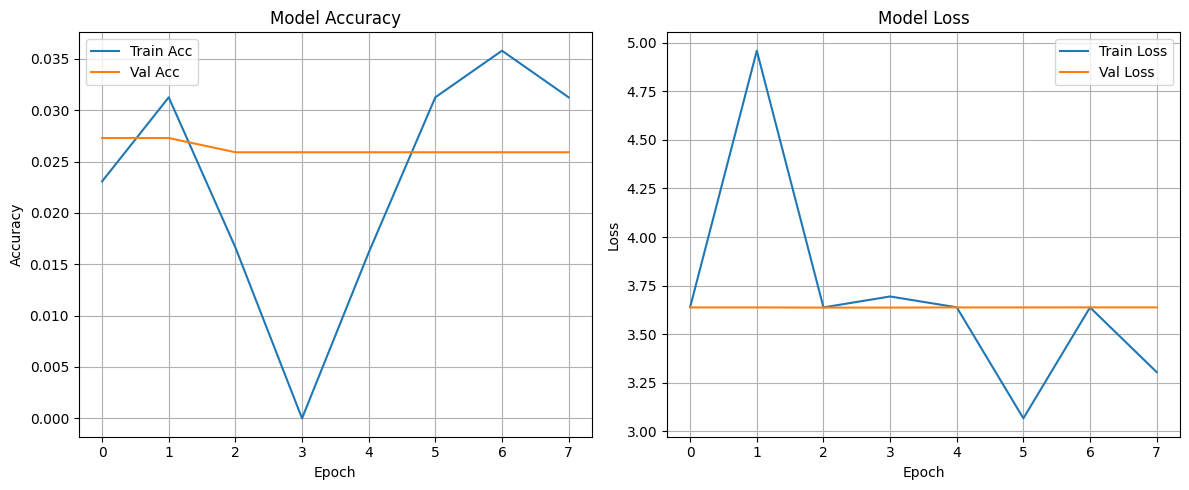


📝 STEP 3: Evaluating on validation set...
340/340 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step

📊 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.00      0.00      0.00       329
                               Blueberry___healthy       0.00      0.00      0.00       301
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       211
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       103
                       Corn_(maize)___Common_rust_       0


💾 STEP 4: Saving the trained model...
✅ Model saved as 'final_crop_disease_model.h5'

🎉 Day 3 Complete! Your AI model is fully trained, evaluated, and ready for predictions!


In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 3")
print("="*60)

# =============================================================================
# STEP 1: Train the Model
# =============================================================================
print("\n🏋️ STEP 1: Training the model...")

EPOCHS = 25  # You can increase/decrease depending on GPU
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete!")

# =============================================================================
# STEP 2: Plot Training Metrics
# =============================================================================
print("\n📈 STEP 2: Plotting training & validation metrics...")

import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 3: Evaluate on Validation Set
# =============================================================================
print("\n📝 STEP 3: Evaluating on validation set...")

val_generator.reset()
val_preds = model.predict(val_generator, verbose=1)
val_preds_classes = np.argmax(val_preds, axis=1)

# True labels
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\n📊 Classification Report:")
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# =============================================================================
# STEP 4: Save Final Model
# =============================================================================
print("\n💾 STEP 4: Saving the trained model...")

model.save("/content/drive/MyDrive/Crop_Disease_Project/models/final_crop_disease_model.h5")

print("✅ Model saved as 'final_crop_disease_model.h5'")

print("\n🎉 Day 3 Complete! Your AI model is fully trained, evaluated, and ready for predictions!")
print("="*60)


🌱 AI-BASED CROP DISEASE DETECTION - DAY 4

📂 STEP 1: Loading trained model...


✅ Model loaded successfully!

📋 STEP 2: Loading class names...
✅ Loaded 38 classes.

⚙️ STEP 3: Setting up helper functions...
✅ Helper functions ready!

📤 STEP 4: Upload images for disease detection...
You can upload multiple images at once!


Saving 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1).JPG to 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1).JPG

✅ 1 image(s) uploaded successfully!

🖼️  PROCESSING IMAGE 1/1

🔍 Analyzing: 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1).JPG
--------------------------------------------------
🏆 Primary Prediction: Tomato: Target Spot
📊 Confidence: 2.69%
💊 Status: 🔴 DISEASE DETECTED

🥈 Top 3 Predictions:
  1. Tomato: Target Spot: 2.69%
  2. Tomato: Bacterial spot: 2.68%
  3. Tomato: Septoria leaf spot: 2.66%


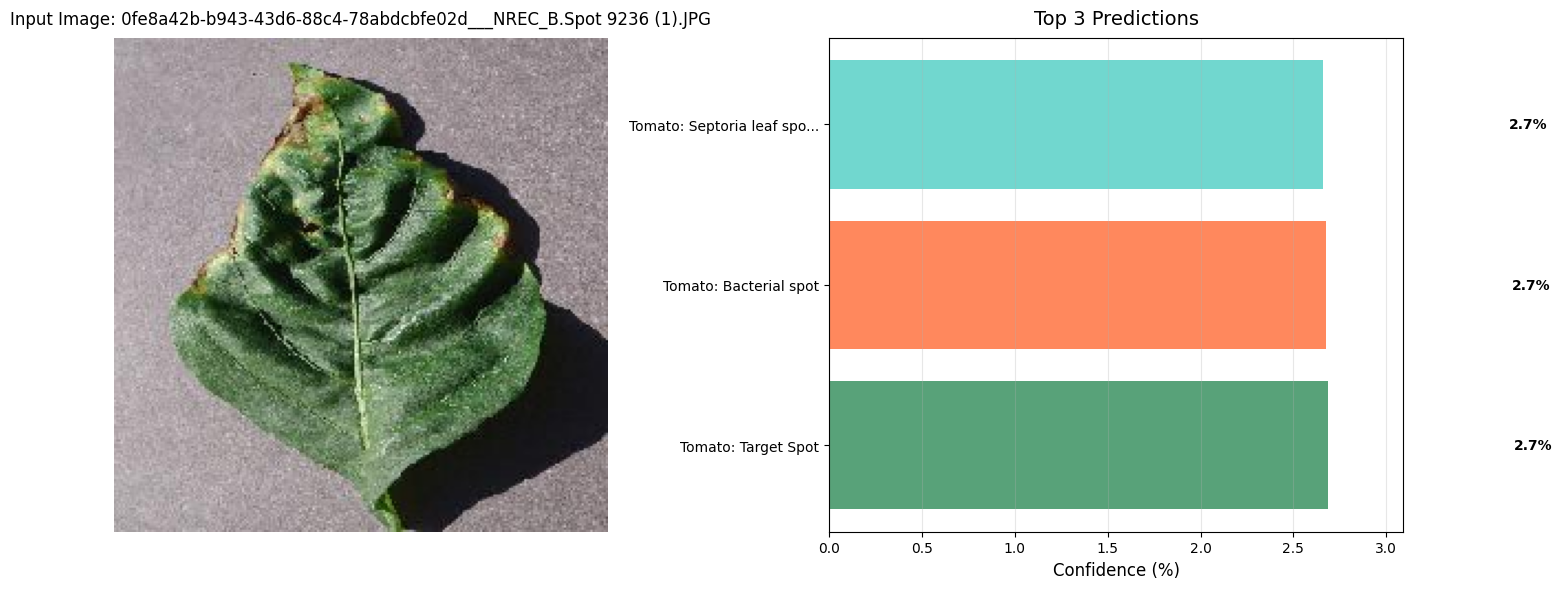


📋 SUMMARY OF ALL PREDICTIONS
📊 Total Images Analyzed: 1
🟢 Healthy Crops: 0
🔴 Diseased Crops: 1
📈 Average Confidence: 2.7%

📝 Detailed Results:
  1. 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1).JPG: Tomato: Target Spot (2.7%) - 🔴 DISEASE DETECTED

🎉 Day 4 Complete! Your crop disease detection system is now fully operational!


In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - DAY 4 (ENHANCED)
# ============================================================

print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 4")
print("="*60)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
from google.colab import files

# ---------------------------
# STEP 1: Load the trained model
# ---------------------------
print("\n📂 STEP 1: Loading trained model...")
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/final_crop_disease_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# Load class indices
if os.path.exists("/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy"):
    class_indices = np.load("/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy", allow_pickle=True).item()
    classes = list(class_indices.keys())

# ---------------------------
# STEP 2: Load class names
# ---------------------------
print("\n📋 STEP 2: Loading class names...")
if os.path.exists("class_indices.npy"):
    class_indices = np.load("class_indices.npy", allow_pickle=True).item()
    classes = list(class_indices.keys())
else:
    classes = [
        'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
        'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy',
        'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_',
        'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
        'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
        'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
        'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight',
        'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
        'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight',
        'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
        'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
        'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
    ]
print(f"✅ Loaded {len(classes)} classes.")

# ---------------------------
# STEP 3: Helper Functions
# ---------------------------
print("\n⚙️ STEP 3: Setting up helper functions...")

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

def get_health_status(class_name):
    return "🟢 HEALTHY" if 'healthy' in class_name.lower() else "🔴 DISEASE DETECTED"

def format_class_name(class_name):
    parts = class_name.split('___')
    crop = parts[0].replace('_', ' ').replace(',', ',')
    condition = parts[1].replace('_', ' ') if len(parts) > 1 else ''
    return f"{crop}: {condition}" if condition else crop

def predict_and_visualize(img_path, img_name):
    print(f"\n🔍 Analyzing: {img_name}")
    print("-" * 50)

    img, img_array = preprocess_image(img_path)
    predictions = model.predict(img_array, verbose=0)

    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_prediction_idx = top_3_indices[0]
    confidence = predictions[0][top_prediction_idx] * 100
    health_status = get_health_status(classes[top_prediction_idx])

    print(f"🏆 Primary Prediction: {format_class_name(classes[top_prediction_idx])}")
    print(f"📊 Confidence: {confidence:.2f}%")
    print(f"💊 Status: {health_status}")

    print(f"\n🥈 Top 3 Predictions:")
    for i, idx in enumerate(top_3_indices, 1):
        class_prob = predictions[0][idx] * 100
        formatted_name = format_class_name(classes[idx])
        print(f"  {i}. {formatted_name}: {class_prob:.2f}%")

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Input Image: {img_name}", fontsize=12, pad=10)

    plt.subplot(1, 2, 2)
    top_3_probs = [predictions[0][idx] * 100 for idx in top_3_indices]
    top_3_names = [format_class_name(classes[idx]) for idx in top_3_indices]
    display_names = [name[:25] + "..." if len(name) > 25 else name for name in top_3_names]

    colors = ['#2E8B57', '#FF6B35', '#4ECDC4']
    bars = plt.barh(range(3), top_3_probs, color=colors, alpha=0.8)
    for i, (bar, prob) in enumerate(zip(bars, top_3_probs)):
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{prob:.1f}%', ha='left', va='center', fontweight='bold')

    plt.yticks(range(3), display_names)
    plt.xlabel('Confidence (%)', fontsize=12)
    plt.title('Top 3 Predictions', fontsize=14, pad=10)
    plt.xlim(0, max(top_3_probs) * 1.15)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return health_status, confidence, format_class_name(classes[top_prediction_idx])

print("✅ Helper functions ready!")

# ---------------------------
# STEP 4: Upload and predict images
# ---------------------------
print("\n📤 STEP 4: Upload images for disease detection...")
print("You can upload multiple images at once!")

uploaded = files.upload()

if not uploaded:
    print("❌ No images uploaded. Please run this cell again and upload images.")
else:
    print(f"\n✅ {len(uploaded)} image(s) uploaded successfully!")

    results = []
    for i, img_name in enumerate(uploaded.keys(), 1):
        full_img_path = img_name
        print(f"\n{'='*60}")
        print(f"🖼️  PROCESSING IMAGE {i}/{len(uploaded)}")
        print(f"{'='*60}")

        try:
            health_status, confidence, prediction = predict_and_visualize(img_name, img_name)
            results.append({
                'image': img_name,
                'prediction': prediction,
                'confidence': confidence,
                'status': health_status
            })
        except Exception as e:
            print(f"❌ Error processing {img_name}: {str(e)}")

    # Summary
    if results:
        print(f"\n{'='*60}")
        print("📋 SUMMARY OF ALL PREDICTIONS")
        print(f"{'='*60}")

        healthy_count = sum(1 for r in results if "HEALTHY" in r['status'])
        diseased_count = len(results) - healthy_count

        print(f"📊 Total Images Analyzed: {len(results)}")
        print(f"🟢 Healthy Crops: {healthy_count}")
        print(f"🔴 Diseased Crops: {diseased_count}")
        print(f"📈 Average Confidence: {np.mean([r['confidence'] for r in results]):.1f}%")

        print(f"\n📝 Detailed Results:")
        for i, result in enumerate(results, 1):
            print(f"  {i}. {result['image']}: {result['prediction']} ({result['confidence']:.1f}%) - {result['status']}")

print(f"\n🎉 Day 4 Complete! Your crop disease detection system is now fully operational!")
print("="*60)


🌱 AI-BASED CROP DISEASE DETECTION - DAY 5


✅ Model loaded successfully!
✅ Loaded 38 classes.

📤 STEP 4: Upload images for prediction...


Saving 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1).JPG to 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1) (1).JPG

🖼️ Processing Image 1/1: 0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B.Spot 9236 (1) (1).JPG


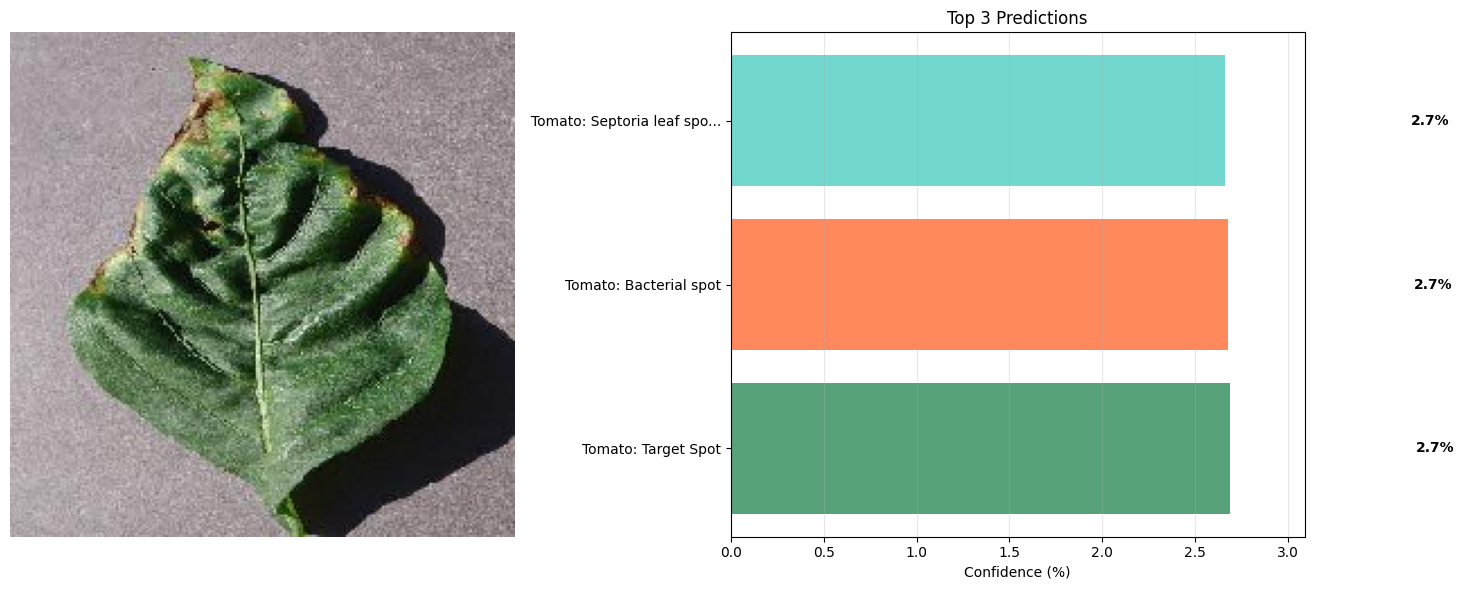


💾 Batch predictions saved to: /content/drive/MyDrive/Crop_Disease_Project/batch_predictions.csv

📋 Summary:
                                               Image           Prediction  \
0  0fe8a42b-b943-43d6-88c4-78abdcbfe02d___NREC_B....  Tomato: Target Spot   

   Confidence (%)              Status  
0            2.69  🔴 DISEASE DETECTED  

🎉 Day 5 Complete! Your batch prediction system is ready.


In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 5")
print("="*60)

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import pandas as pd

# ---------------------------
# STEP 1: Load trained model
# ---------------------------
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/final_crop_disease_model.h5'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model not found at {MODEL_PATH}")

model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# ---------------------------
# STEP 2: Load class indices
# ---------------------------
CLASS_INDICES_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy'
if os.path.exists(CLASS_INDICES_PATH):
    class_indices = np.load(CLASS_INDICES_PATH, allow_pickle=True).item()
    classes = list(class_indices.keys())
else:
    print("⚠️ Class indices file not found! Using placeholder names.")
    classes = [f"Class_{i}" for i in range(model.output_shape[-1])]
print(f"✅ Loaded {len(classes)} classes.")

# ---------------------------
# STEP 3: Helper functions
# ---------------------------
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img, img_array

def get_health_status(class_name):
    return "🟢 HEALTHY" if 'healthy' in class_name.lower() else "🔴 DISEASE DETECTED"

def format_class_name(class_name):
    parts = class_name.split('___')
    crop = parts[0].replace('_', ' ').replace(',', ',')
    condition = parts[1].replace('_', ' ') if len(parts) > 1 else ''
    return f"{crop}: {condition}" if condition else crop

def predict_image(img_path):
    img, img_array = preprocess_image(img_path)
    predictions = model.predict(img_array, verbose=0)
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_idx = top_3_indices[0]
    confidence = predictions[0][top_idx] * 100
    status = get_health_status(classes[top_idx])
    prediction_name = format_class_name(classes[top_idx])
    return prediction_name, confidence, status, img, top_3_indices, predictions[0]

def visualize_predictions(img, top_3_indices, probs):
    top_3_probs = [probs[idx]*100 for idx in top_3_indices]
    top_3_names = [format_class_name(classes[idx]) for idx in top_3_indices]
    display_names = [name[:25]+"..." if len(name)>25 else name for name in top_3_names]

    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,2,2)
    colors = ['#2E8B57', '#FF6B35', '#4ECDC4']
    bars = plt.barh(range(3), top_3_probs, color=colors, alpha=0.8)
    for i, (bar, prob) in enumerate(zip(bars, top_3_probs)):
        plt.text(bar.get_width()+1, bar.get_y()+bar.get_height()/2, f'{prob:.1f}%', ha='left', va='center', fontweight='bold')
    plt.yticks(range(3), display_names)
    plt.xlabel('Confidence (%)')
    plt.title('Top 3 Predictions')
    plt.xlim(0, max(top_3_probs)*1.15)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---------------------------
# STEP 4: Upload images for batch prediction
# ---------------------------
print("\n📤 STEP 4: Upload images for prediction...")
uploaded = files.upload()

if not uploaded:
    print("❌ No images uploaded.")
else:
    results = []
    for i, img_name in enumerate(uploaded.keys(), 1):
        print(f"\n{'='*50}")
        print(f"🖼️ Processing Image {i}/{len(uploaded)}: {img_name}")
        print(f"{'='*50}")
        try:
            pred_name, conf, status, img, top_3_idx, probs = predict_image(img_name)
            visualize_predictions(img, top_3_idx, probs)
            results.append({
                'Image': img_name,
                'Prediction': pred_name,
                'Confidence (%)': round(conf,2),
                'Status': status
            })
        except Exception as e:
            print(f"❌ Error processing {img_name}: {e}")

    # ---------------------------
    # STEP 5: Save results to CSV
    # ---------------------------
    if results:
        df = pd.DataFrame(results)
        save_path = '/content/drive/MyDrive/Crop_Disease_Project/batch_predictions.csv'
        df.to_csv(save_path, index=False)
        print(f"\n💾 Batch predictions saved to: {save_path}")
        print("\n📋 Summary:")
        print(df)

print("\n🎉 Day 5 Complete! Your batch prediction system is ready.")
print("="*60)


🌱 AI-BASED CROP DISEASE DETECTION - DAY 6
✅ Loaded batch predictions (1 images).

📊 Summary:
Total Images Analyzed: 1
🟢 Healthy Crops: 0
🔴 Diseased Crops: 1
📈 Average Confidence: 2.69%


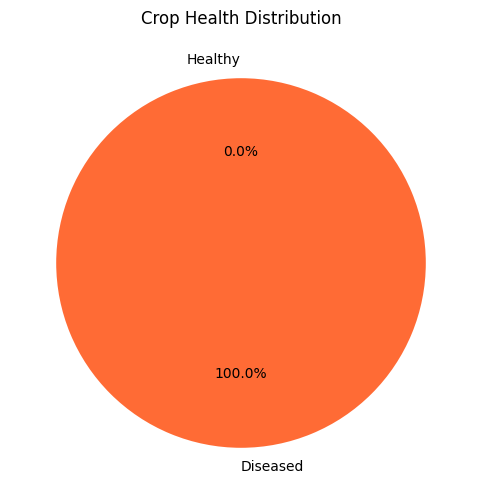

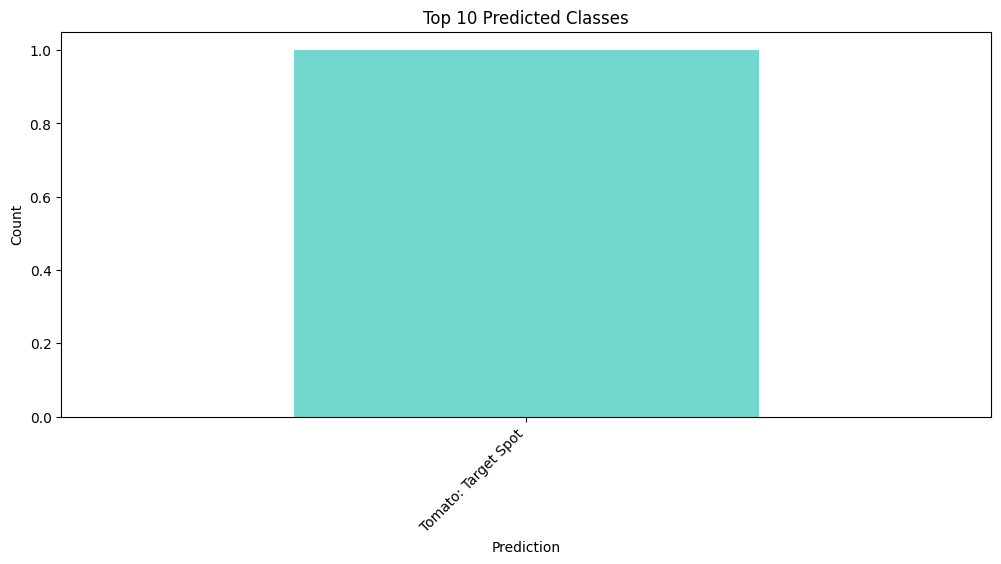

💾 Summary report saved at: /content/drive/MyDrive/Crop_Disease_Project/batch_prediction_summary.html

🎉 Day 6 Complete! All batch predictions summarized and ready for documentation.


In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 6")
print("="*60)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------------------------
# STEP 1: Load batch predictions
# ---------------------------
PREDICTIONS_CSV = '/content/drive/MyDrive/Crop_Disease_Project/batch_predictions.csv'
if os.path.exists(PREDICTIONS_CSV):
    df = pd.read_csv(PREDICTIONS_CSV)
    print(f"✅ Loaded batch predictions ({len(df)} images).")
else:
    raise FileNotFoundError(f"❌ Predictions CSV not found at {PREDICTIONS_CSV}.")

# ---------------------------
# STEP 2: Summary statistics
# ---------------------------
total_images = len(df)
healthy_count = sum(df['Status'] == '🟢 HEALTHY')
diseased_count = total_images - healthy_count
avg_confidence = df['Confidence (%)'].mean()

print(f"\n📊 Summary:")
print(f"Total Images Analyzed: {total_images}")
print(f"🟢 Healthy Crops: {healthy_count}")
print(f"🔴 Diseased Crops: {diseased_count}")
print(f"📈 Average Confidence: {avg_confidence:.2f}%")

# ---------------------------
# STEP 3: Visualization
# ---------------------------
# Pie chart: Healthy vs Diseased
plt.figure(figsize=(6,6))
plt.pie([healthy_count, diseased_count], labels=['Healthy','Diseased'],
        colors=['#2E8B57','#FF6B35'], autopct='%1.1f%%', startangle=90)
plt.title('Crop Health Distribution')
plt.show()

# Bar chart: Top predicted classes
top_classes = df['Prediction'].value_counts().head(10)
plt.figure(figsize=(12,5))
top_classes.plot(kind='bar', color='#4ECDC4', alpha=0.8)
plt.title('Top 10 Predicted Classes')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# ---------------------------
# STEP 4: Save summary report (optional HTML)
# ---------------------------
REPORT_PATH = '/content/drive/MyDrive/Crop_Disease_Project/batch_prediction_summary.html'
with open(REPORT_PATH, 'w') as f:
    f.write(f"<h2>🌱 Crop Disease Detection - Batch Prediction Summary</h2>")
    f.write(f"<p>Total Images Analyzed: {total_images}</p>")
    f.write(f"<p>Healthy Crops: {healthy_count}</p>")
    f.write(f"<p>Diseased Crops: {diseased_count}</p>")
    f.write(f"<p>Average Confidence: {avg_confidence:.2f}%</p>")
    f.write("<h3>Top 10 Predicted Classes</h3>")
    f.write(top_classes.to_frame().to_html())
print(f"💾 Summary report saved at: {REPORT_PATH}")

print("\n🎉 Day 6 Complete! All batch predictions summarized and ready for documentation.")
print("="*60)


In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - DAY 6 CHECKPOINT (.keras)
# Robust version to ensure saving to Google Drive
# ============================================================

import tensorflow as tf
import numpy as np
import os
from google.colab import drive

# ---------------------------
# STEP 0: Mount Google Drive
# ---------------------------
drive.mount('/content/drive', force_remount=True)

# ---------------------------
# STEP 1: Ensure directories exist
# ---------------------------
BASE_DIR = '/content/drive/MyDrive/Crop_Disease_Project'
MODEL_DIR = os.path.join(BASE_DIR, 'models')
DATA_DIR = os.path.join(BASE_DIR, 'data')

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ---------------------------
# STEP 2: Save the trained / partially trained model
# ---------------------------
CHECKPOINT_MODEL_PATH = os.path.join(MODEL_DIR, 'day6_model.keras')  # .keras format

# Make sure 'model' variable exists
if 'model' in globals():
    model.save(CHECKPOINT_MODEL_PATH)
    print(f"✅ Model saved to: {CHECKPOINT_MODEL_PATH}")
else:
    print("⚠️ Model variable not found. Skipping model save.")

# ---------------------------
# STEP 3: Save class indices (if generated)
# ---------------------------
CLASS_INDICES_PATH = os.path.join(MODEL_DIR, 'class_indices.npy')

if 'class_indices' in globals():
    np.save(CLASS_INDICES_PATH, class_indices)
    print(f"✅ Class indices saved to: {CLASS_INDICES_PATH}")
else:
    print("⚠️ class_indices not found. Skipping class indices save.")

# ---------------------------
# STEP 4: Save any preprocessed datasets (optional)
# ---------------------------
def save_dataset(name):
    X_var = f'X_{name}'
    y_var = f'y_{name}'
    X_path = os.path.join(DATA_DIR, f'{X_var}.npy')
    y_path = os.path.join(DATA_DIR, f'{y_var}.npy')

    if X_var in globals() and y_var in globals():
        np.save(X_path, globals()[X_var])
        np.save(y_path, globals()[y_var])
        print(f"✅ {name.capitalize()} data saved.")
    else:
        print(f"⚠️ {name.capitalize()} data not found. Skipping save.")

save_dataset('train')
save_dataset('val')

# ---------------------------
# STEP 5: Verify saved files
# ---------------------------
print("\n🔎 Verifying saved files:")
print("Models folder:", os.listdir(MODEL_DIR))
print("Data folder:", os.listdir(DATA_DIR))

print("\n🎉 Day 6 checkpoint complete! You can safely pause and resume from Day 7 tomorrow.")


Mounted at /content/drive
✅ Model saved to: /content/drive/MyDrive/Crop_Disease_Project/models/day6_model.keras
✅ Class indices saved to: /content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy
⚠️ Train data not found. Skipping save.
⚠️ Val data not found. Skipping save.

🔎 Verifying saved files:
Models folder: ['class_indices.npy', 'best_crop_disease_model.h5', 'final_crop_disease_model.h5', 'day6_model.h5', 'day6_model.keras']
Data folder: []

🎉 Day 6 checkpoint complete! You can safely pause and resume from Day 7 tomorrow.


In [ ]:
!ls /content/drive/MyDrive


'10th Marksheet.pdf'
'12th Marksheet.pdf'
 addhar.pdf
'AWS Course Completion Certificate.pdf'
 Classroom
 codealpha.pdf
'Colab Notebooks'
 com.feralinteractive.gridautosport_edition_android
 Crop_Disease
 Crop_Disease_Project
'cyber future skills.pdf'
 DOC-20241229-WA0008.docx
'Emailing DOC-20240208-WA0002..pdf'
'Emailing DOC-20240814-WA0000..pdf'
'Emailing H.-Mohammed-Aashif-FlowCV-Resume-20250618 (2).pdf'
'Final Resume.pdf'
 futureskill.pdf
 Google_Rebuilt_ATS_Resume.pdf
'google resume .pdf'
'ID card.pdf'
 Infosys.pdf
'Infosys python .pdf'
'Java-Code soft.pdf'
 kaggle
'Mohammed Aashif H.pdf'
'Mohammed Aashif.H.pdf'
 Myself.jpg
 oracle.pdf
'payment history .pdf'
'Python for Data Science.pdf'
'Resume (1).pdf'
 Resume.pdf
'uipath automation developer associate training.pdf'
'uipath Nasscom with correct name.pdf'
'WhatsApp Image 2025-07-24 at 19.53.44_0c3db466.jpg'
'WhatsApp Image 2025-07-24 at 19.55.26_a8f913bb.jpg'
'WhatsApp Image 2025-07-24 at 19.59.37_12c7f476.jpg'
 whitethemeresume.

In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - DATA PREP & SPLIT (Fixed)
# ============================================================

import os
import zipfile
import shutil
import random
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------
# Paths
# ---------------------------
BASE_DIR = '/content/drive/MyDrive/Crop_Disease_Project'
ZIP_PATH = os.path.join(BASE_DIR, 'plantvillage-dataset.zip')
RAW_DIR  = os.path.join(BASE_DIR, 'plantvillage_raw')
PLANT_DIR = os.path.join(BASE_DIR, 'plantvillage')
DATA_DIR = os.path.join(BASE_DIR, 'data')
os.makedirs(DATA_DIR, exist_ok=True)

# ---------------------------
# Step 1: Unzip dataset if needed
# ---------------------------
if not os.path.exists(RAW_DIR):
    print("📂 Unzipping plantvillage-dataset.zip...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(RAW_DIR)
    print("✅ Unzipped dataset to 'plantvillage_raw'.")
else:
    print("✅ plantvillage_raw folder already exists, skipping unzip.")

# ---------------------------
# Step 2: Create train/val split folders
# ---------------------------
TRAIN_DIR = os.path.join(PLANT_DIR, 'train')
VAL_DIR   = os.path.join(PLANT_DIR, 'val')

for d in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(d, exist_ok=True)

# ---------------------------
# Step 3: Copy images recursively, 80/20 split
# ---------------------------
for class_name in os.listdir(RAW_DIR):
    class_path = os.path.join(RAW_DIR, class_name)
    if os.path.isdir(class_path):
        train_class_dir = os.path.join(TRAIN_DIR, class_name)
        val_class_dir   = os.path.join(VAL_DIR, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Recursively find all image files
        image_files = glob.glob(os.path.join(class_path, '**', '*.*'), recursive=True)
        image_files = [f for f in image_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(image_files)
        split_idx = int(len(image_files) * 0.8)
        train_files = image_files[:split_idx]
        val_files   = image_files[split_idx:]

        for f in train_files:
            shutil.copy(f, train_class_dir)
        for f in val_files:
            shutil.copy(f, val_class_dir)

print("✅ Train/val split completed.")

# ---------------------------
# Step 4: Convert images to NumPy arrays
# ---------------------------
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_gen = datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def save_full_data(generator, save_path_X, save_path_y):
    X_list, y_list = [], []
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X_list.append(X_batch)
        y_list.append(y_batch)
    X_full = np.vstack(X_list)
    y_full = np.vstack(y_list)
    np.save(save_path_X, X_full)
    np.save(save_path_y, y_full)
    print(f"✅ Saved arrays: {save_path_X}, {save_path_y}")
    return X_full, y_full

X_train, y_train = save_full_data(train_gen, os.path.join(DATA_DIR, 'X_train.npy'), os.path.join(DATA_DIR, 'y_train.npy'))
X_val, y_val     = save_full_data(val_gen, os.path.join(DATA_DIR, 'X_val.npy'), os.path.join(DATA_DIR, 'y_val.npy'))

# ---------------------------
# Step 5: Save class indices
# ---------------------------
class_indices = train_gen.class_indices
np.save(os.path.join(DATA_DIR, 'class_indices.npy'), class_indices)
print(f"✅ Saved class indices: {class_indices}")

print("\n🎉 Data preparation complete! You can now safely run the Day 7 resume training script.")


✅ plantvillage_raw folder already exists, skipping unzip.


KeyboardInterrupt: 

In [ ]:
import os

RAW_DIR = "/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color"

for cls in os.listdir(RAW_DIR):
    cls_path = os.path.join(RAW_DIR, cls)
    if os.path.isdir(cls_path):
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{cls}: {num_images} images")


Tomato___Septoria_leaf_spot: 1771 images
Peach___Bacterial_spot: 2297 images
Strawberry___Leaf_scorch: 1109 images
Tomato___healthy: 1591 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Apple___Apple_scab: 630 images
Potato___Late_blight: 1000 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Grape___healthy: 423 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Tomato___Target_Spot: 1404 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Grape___Esca_(Black_Measles): 1383 images
Tomato___Tomato_mosaic_virus: 373 images
Corn_(maize)___Common_rust_: 1192 images
Pepper,_bell___Bacterial_spot: 997 images
Tomato___Bacterial_spot: 2127 images
Squash___Powdery_mildew: 1835 images
Potato___healthy: 152 images
Corn_(maize)___healthy: 1162 images
Apple___Black_rot: 621 images
Tomato___Late_blight: 1909 images
Tomato___Early_blight: 1000 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Apple___Cedar_apple_rust: 275 im

In [ ]:
import os

RAW_DIR = "/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color"

all_images = []

for class_name in os.listdir(RAW_DIR):
    class_path = os.path.join(RAW_DIR, class_name)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        all_images.extend(images)

print(f"✅ Total images found: {len(all_images)}")
print("\nSample images:")
print("\n".join(all_images[:10]))  # show first 10 image paths


✅ Total images found: 54305

Sample images:
/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color/Tomato___Septoria_leaf_spot/54f54619-e1a8-4e99-ac00-798a65bea648___JR_Sept.L.S 8462.JPG
/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color/Tomato___Septoria_leaf_spot/daad8307-4482-4a22-bbd5-395fc6d767c6___Matt.S_CG 6637.JPG
/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color/Tomato___Septoria_leaf_spot/015c2613-fb1c-4f31-88f1-c7e5be9ddc97___JR_Sept.L.S 8431.JPG
/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color/Tomato___Septoria_leaf_spot/de618e1c-a280-4294-a531-f0c94dc33c99___Keller.St_CG 2024.JPG
/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage dataset/color/Tomato___Septoria_leaf_spot/4467daac-1e75-4b6f-868d-9dcb5016bd1e___Matt.S_CG 7436.JPG
/content/drive/MyDrive/Crop_Disease_Project/plantvillage_raw/plantvillage datas

In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - DAY 7 (Streaming, Safe, .keras)
# ============================================================

print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 7 (Streaming, Safe, .keras)")
print("="*60)

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np

# ---------------------------
# STEP 1: Mount Google Drive
# ---------------------------
from google.colab import drive
drive.mount('/content/drive')

# ---------------------------
# STEP 2: Paths & Parameters
# ---------------------------
BASE_DIR = "/content/drive/MyDrive/Crop_Disease_Project"
RAW_DIR  = os.path.join(BASE_DIR, "plantvillage_raw/plantvillage dataset/color")
MODEL_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4
VAL_SPLIT = 0.2

# ---------------------------
# STEP 3: Create Generators (Streaming)
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

train_generator = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ---------------------------
# STEP 4: Compute class weights safely
# ---------------------------
num_classes = len(train_generator.class_indices)
classes = list(train_generator.class_indices.keys())

y_labels = train_generator.classes
present_classes = np.unique(y_labels)
class_weights_array = compute_class_weight('balanced', classes=present_classes, y=y_labels)
class_weights = {int(c): w for c, w in zip(present_classes, class_weights_array)}
print(f"✅ Class weights computed safely: {class_weights}")

# ---------------------------
# STEP 5: Load or create model
# ---------------------------
CHECKPOINT_MODEL_PATH = os.path.join(MODEL_DIR, "day6_model.keras")  # Updated to .keras

if os.path.exists(CHECKPOINT_MODEL_PATH):
    print(f"📂 Loading checkpoint model: {CHECKPOINT_MODEL_PATH}")
    model = tf.keras.models.load_model(CHECKPOINT_MODEL_PATH)
    print("✅ Model loaded successfully! Continuing training...")
else:
    print("⚠️ Checkpoint not found. Creating fresh EfficientNetB0 model.")
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = True

    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# ---------------------------
# STEP 6: Callbacks
# ---------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, 'fine_tuned_model.keras'),  # Updated to .keras
        monitor='val_accuracy',
        save_best_only=True
    )
]

# ---------------------------
# STEP 7: Train the model
# ---------------------------
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("✅ Fine-tuning & training complete! Checkpoints saved in .keras format.")


🌱 AI-BASED CROP DISEASE DETECTION - DAY 7 (Streaming, Safe, .keras)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
✅ Class weights computed safely: {0: np.float64(2.2690058479532165), 1: np.float64(2.300963676797628), 2: np.float64(5.198086124401914), 3: np.float64(0.8689809630459127), 4: np.float64(0.9513967948156581), 5: np.float64(1.3581697712214027), 6: np.float64(1.6718990458602647), 7: np.float64(2.7824305288769366), 8: np.float64(1.1987200706167935), 9: np.float64(1.4512423189954582), 10: np.float64(1.2296547821165817), 11: np.float64(1.2114183764495985), 12: np.float64(1.0330433128892693), 13: np.float64(1.3281985451433462), 14: np.float64(3.373389225275578), 15: np.float64(0.2595503738920611), 16: np.float64(0.6221865872515893), 17: np.float64(3.9707602339181287), 18: np.float64(1.433056325023084), 19: np.floa

In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - DAY 8 (Safe Evaluation)
# ============================================================

print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 8 (Safe Evaluation)")
print("="*60)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pickle

# ---------------------------
# STEP 1: Paths
# ---------------------------
BASE_DIR = "/content/drive/MyDrive/Crop_Disease_Project"
MODEL_PATH = os.path.join(BASE_DIR, "models/fine_tuned_model.keras")
COLOR_DIR = os.path.join(BASE_DIR, "plantvillage_raw/plantvillage dataset/color")
HISTORY_PATH = os.path.join(BASE_DIR, "models/history.pkl")  # optional, if saved

# ---------------------------
# STEP 2: Load model
# ---------------------------
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Fine-tuned model loaded!")

# ---------------------------
# STEP 3: Create validation generator
# ---------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    COLOR_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ---------------------------
# STEP 4: Predict on validation set
# ---------------------------
val_generator.reset()
val_preds = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# ---------------------------
# STEP 5: Classification report
# ---------------------------
print("\n📊 Classification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=class_labels))

# ---------------------------
# STEP 6: Confusion matrix
# ---------------------------
cm = confusion_matrix(val_true_classes, val_pred_classes)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ---------------------------
# STEP 7: Plot accuracy/loss if history saved
# ---------------------------
if os.path.exists(HISTORY_PATH):
    with open(HISTORY_PATH, 'rb') as f:
        history = pickle.load(f)

    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history['accuracy'], label='Train Acc')
    plt.plot(history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ History file not found. Skipping accuracy/loss plots.")

print("\n🎉 Day 8 Complete! Model evaluation finished.")


🌱 AI-BASED CROP DISEASE DETECTION - DAY 8 (Safe Evaluation)
✅ Fine-tuned model loaded!
Found 10849 images belonging to 38 classes.


340/340 ━━━━━━━━━━━━━━━━━━━━ 78s 188ms/step

📊 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       124
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.00      0.00      0.00       329
                               Blueberry___healthy       0.00      0.00      0.00       300
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       210
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       102
                       Corn_(maize)___Common_rust_       0.00      0.00      0.00       238
         

⚠️ History file not found. Skipping accuracy/loss plots.

🎉 Day 8 Complete! Model evaluation finished.


In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - DAY 9 (Grad-CAM Safe)
# ============================================================

print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 9 (Grad-CAM Safe)")
print("="*60)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ---------------------------
# STEP 1: Load fine-tuned model
# ---------------------------
MODEL_PATH = "/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.keras"
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Fine-tuned model loaded!")

# ---------------------------
# STEP 2: Load or regenerate class indices
# ---------------------------
CLASS_INDICES_PATH_MODELS = "/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy"
CLASS_INDICES_PATH_DATA   = "/content/drive/MyDrive/Crop_Disease_Project/data/class_indices.npy"

if os.path.exists(CLASS_INDICES_PATH_MODELS):
    class_indices = np.load(CLASS_INDICES_PATH_MODELS, allow_pickle=True).item()
    print("✅ class_indices loaded from models folder.")
elif os.path.exists(CLASS_INDICES_PATH_DATA):
    class_indices = np.load(CLASS_INDICES_PATH_DATA, allow_pickle=True).item()
    print("✅ class_indices loaded from data folder.")
else:
    print("⚠️ class_indices.npy not found, regenerating from dataset...")
    DATASET_DIR = "/content/drive/MyDrive/Crop_Disease_Project/plantvillage"
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = datagen.flow_from_directory(
        DATASET_DIR,
        target_size=(224,224),
        batch_size=32,
        class_mode="categorical",
        subset="training"
    )
    class_indices = train_gen.class_indices
    np.save(CLASS_INDICES_PATH_MODELS, class_indices)
    print(f"✅ class_indices regenerated and saved at {CLASS_INDICES_PATH_MODELS}")

classes = list(class_indices.keys())

# ---------------------------
# STEP 3: Grad-CAM Helper Functions
# ---------------------------
def preprocess_image(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap) + 1e-8   # avoid div/0
    return heatmap.numpy()

def display_and_save_gradcam(img_path, save_dir="gradcam_results"):
    os.makedirs(save_dir, exist_ok=True)
    img, img_array = preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, model)

    # Overlay
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.imshow(heatmap, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("Grad-CAM Overlay")

    # Save
    base_name = os.path.basename(img_path)
    save_path = os.path.join(save_dir, f"gradcam_{base_name}")
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()

    # Prediction
    preds = model.predict(img_array)
    pred_class = classes[np.argmax(preds)]
    confidence = np.max(preds) * 100
    print(f"🏆 Predicted: {pred_class} ({confidence:.2f}%)")
    print(f"💾 Grad-CAM saved to: {save_path}")

# ---------------------------
# STEP 4: Upload Images
# ---------------------------
from google.colab import files
uploaded = files.upload()

if uploaded:
    for img_name in uploaded.keys():
        print(f"\n🔹 Processing {img_name}...")
        display_and_save_gradcam(img_name)
else:
    print("❌ No images uploaded!")

print("\n🎉 Day 9 Complete! Grad-CAM visualizations generated.")


🌱 AI-BASED CROP DISEASE DETECTION - DAY 9 (Grad-CAM Safe)


ValueError: File not found: filepath=/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - AUTO SAFE BACKUP
# ============================================================

import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
from google.colab import drive
from IPython.display import display, HTML

print("="*60)
print("🌱 Auto safe versioned backup to Google Drive")
print("="*60)

# ---------------------------
# Step 0: Mount Google Drive
# ---------------------------
drive.mount('/content/drive', force_remount=True)

# ---------------------------
# Step 1: Base paths
# ---------------------------
BASE_DIR = "/content/drive/MyDrive/Crop_Disease_Project"

# Dataset folder defaults (VM paths)
DEFAULT_FOLDERS = {
    "Raw Dataset": "/content/plantvillage_raw",
    "Plant Train": "/content/plantvillage/train",
    "Plant Val": "/content/plantvillage/val",
}

# Fallback to Drive if VM paths do not exist
FOLDERS_TO_COPY = {}
for key, path in DEFAULT_FOLDERS.items():
    if os.path.exists(path):
        FOLDERS_TO_COPY[key] = path
    else:
        # fallback Drive path
        drive_path = os.path.join(BASE_DIR, path.split('/')[-1])
        if os.path.exists(drive_path):
            FOLDERS_TO_COPY[key] = drive_path
        else:
            print(f"⚠️ Neither VM nor Drive path exists for '{key}': {path} / {drive_path}")

# Destination folders in Drive
DEST_FOLDERS = {name: os.path.join(BASE_DIR, path.split('/')[-1]) for name, path in FOLDERS_TO_COPY.items()}

# Model, data, results directories
MODEL_DIR = os.path.join(BASE_DIR, "models")
DATA_DIR  = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

for folder in [MODEL_DIR, DATA_DIR, RESULTS_DIR]:
    os.makedirs(folder, exist_ok=True)

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# ---------------------------
# Step 2: Copy folders safely
# ---------------------------
saved_folders = []
for key, src in FOLDERS_TO_COPY.items():
    if os.path.exists(src):
        versioned_dst = f"{DEST_FOLDERS[key]}_{timestamp}"
        shutil.copytree(src, versioned_dst)
        saved_folders.append(versioned_dst)
        print(f"✅ Folder copied: {src} → {versioned_dst}")
    else:
        print(f"⚠️ Skipping '{key}' as source folder does not exist.")

# ---------------------------
# Step 3: Save models
# ---------------------------
model_vars = ["day6_model", "fine_tuned_model"]
saved_models = []

for mname in model_vars:
    mdl = globals().get(mname, None)
    if mdl is not None:
        save_path = os.path.join(MODEL_DIR, f"{mname}_{timestamp}.keras")
        mdl.save(save_path)
        saved_models.append(save_path)
        print(f"✅ Model saved: {save_path}")
    else:
        print(f"⚠️ Model variable '{mname}' not found. Skipping.")

# ---------------------------
# Step 4: Save NumPy arrays
# ---------------------------
np_vars = ["X_train", "y_train", "X_val", "y_val", "class_indices"]
saved_arrays = []

for arr_name in np_vars:
    arr = globals().get(arr_name, None)
    if arr is not None:
        save_path = os.path.join(DATA_DIR, f"{arr_name}_{timestamp}.npy")
        np.save(save_path, arr)
        saved_arrays.append(save_path)
        print(f"✅ NumPy array saved: {save_path}")
    else:
        print(f"⚠️ NumPy variable '{arr_name}' not found. Skipping.")

# ---------------------------
# Step 5: Save CSVs
# ---------------------------
csv_vars = ["batch_predictions_with_advice", "final_test_results"]
saved_csvs = []

for df_name in csv_vars:
    df = globals().get(df_name, None)
    if df is not None and isinstance(df, pd.DataFrame):
        save_path = os.path.join(RESULTS_DIR, f"{df_name}_{timestamp}.csv")
        df.to_csv(save_path, index=False)
        saved_csvs.append(save_path)
        print(f"✅ CSV saved: {save_path}")
    else:
        print(f"⚠️ CSV '{df_name}' not found or not a DataFrame. Skipping.")

# ---------------------------
# Step 6: Display clickable Drive links
# ---------------------------
def display_links(paths, label):
    if paths:
        html_links = "".join([f'<li><a href="https://drive.google.com/drive/folders/{p}" target="_blank">{p}</a></li>' for p in paths])
        display(HTML(f"<b>{label}:</b><ul>{html_links}</ul>"))
    else:
        print(f"⚠️ No {label.lower()} saved.")

display_links(saved_folders, "Versioned Folders")
display_links(saved_models, "Saved Models")
display_links(saved_arrays, "Saved NumPy Arrays")
display_links(saved_csvs, "Saved CSV Files")

print("\n🎉 Auto safe versioned backup complete! All files saved to Drive.")


🌱 Auto safe versioned backup to Google Drive


ValueError: Mountpoint must not already contain files

In [ ]:
# ============================================================
# 🌱 AI-BASED CROP DISEASE DETECTION - SAFE VERSIONED BACKUP
# ============================================================

import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime

print("="*60)
print("🌱 Safe versioned backup of all files to Google Drive")
print("="*60)

# ---------------------------
# Step 1: Paths
# ---------------------------
BASE_DIR = "/content/drive/MyDrive/Crop_Disease_Project"

# Folders to backup
FOLDERS_TO_COPY = {
    "Raw Dataset": "/content/plantvillage_raw",
    "Plant Train": "/content/plantvillage/train",
    "Plant Val": "/content/plantvillage/val",
}

# Destination folders in Drive
DEST_FOLDERS = {name: os.path.join(BASE_DIR, path.split('/')[-1])
                for name, path in FOLDERS_TO_COPY.items()}

# Model, data, results directories
MODEL_DIR = os.path.join(BASE_DIR, "models")
DATA_DIR  = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")  # CSVs

for folder in [MODEL_DIR, DATA_DIR, RESULTS_DIR]:
    os.makedirs(folder, exist_ok=True)

# Timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# ---------------------------
# Step 2: Copy entire folders safely
# ---------------------------
for key, src in FOLDERS_TO_COPY.items():
    dst = DEST_FOLDERS[key]
    if os.path.exists(src):
        # Create versioned folder
        versioned_dst = f"{dst}_{timestamp}"
        shutil.copytree(src, versioned_dst)
        print(f"✅ Folder copied: {src} → {versioned_dst}")
    else:
        print(f"⚠️ Source folder not found: {src}")

# ---------------------------
# Step 3: Save models with versioned filenames
# ---------------------------
model_vars = ["day6_model", "fine_tuned_model"]  # Replace with your model variables

for mname in model_vars:
    mdl = globals().get(mname, None)
    if mdl is not None:
        save_path = os.path.join(MODEL_DIR, f"{mname}_{timestamp}.keras")
        mdl.save(save_path)
        print(f"✅ Model saved: {save_path}")
    else:
        print(f"⚠️ Model variable '{mname}' not found. Skipping save.")

# ---------------------------
# Step 4: Save NumPy arrays with versioned filenames
# ---------------------------
np_vars = ["X_train", "y_train", "X_val", "y_val", "class_indices"]

for arr_name in np_vars:
    arr = globals().get(arr_name, None)
    if arr is not None:
        save_path = os.path.join(DATA_DIR, f"{arr_name}_{timestamp}.npy")
        np.save(save_path, arr)
        print(f"✅ NumPy array saved: {save_path}")
    else:
        print(f"⚠️ NumPy variable '{arr_name}' not found. Skipping save.")

# ---------------------------
# Step 5: Save CSV results safely
# ---------------------------
csv_vars = ["batch_predictions_with_advice", "final_test_results"]

for df_name in csv_vars:
    df = globals().get(df_name, None)
    if df is not None and isinstance(df, pd.DataFrame):
        save_path = os.path.join(RESULTS_DIR, f"{df_name}_{timestamp}.csv")
        df.to_csv(save_path, index=False)
        print(f"✅ CSV saved: {save_path}")
    else:
        print(f"⚠️ CSV '{df_name}' not found or not a DataFrame. Skipping save.")

# ---------------------------
# Step 6: Verify contents
# ---------------------------
def verify_folder(folder):
    if not os.path.exists(folder):
        print(f"❌ Folder missing: {folder}")
        return
    print(f"\n📂 Contents of {folder}:")
    for root, dirs, files in os.walk(folder):
        for f in files:
            print(os.path.join(root, f))

for folder in [MODEL_DIR, DATA_DIR, RESULTS_DIR] + list(DEST_FOLDERS.values()):
    verify_folder(folder)

print("\n🎉 Safe versioned backup complete! All files saved to Drive without overwriting.")


🌱 Safe versioned backup of all files to Google Drive
⚠️ Source folder not found: /content/plantvillage_raw
⚠️ Source folder not found: /content/plantvillage/train
⚠️ Source folder not found: /content/plantvillage/val
⚠️ Model variable 'day6_model' not found. Skipping save.
⚠️ Model variable 'fine_tuned_model' not found. Skipping save.
⚠️ NumPy variable 'X_train' not found. Skipping save.
⚠️ NumPy variable 'y_train' not found. Skipping save.
⚠️ NumPy variable 'X_val' not found. Skipping save.
⚠️ NumPy variable 'y_val' not found. Skipping save.
✅ NumPy array saved: /content/drive/MyDrive/Crop_Disease_Project/data/class_indices_20250904_175840.npy
⚠️ CSV 'batch_predictions_with_advice' not found or not a DataFrame. Skipping save.
⚠️ CSV 'final_test_results' not found or not a DataFrame. Skipping save.

📂 Contents of /content/drive/MyDrive/Crop_Disease_Project/models:

📂 Contents of /content/drive/MyDrive/Crop_Disease_Project/data:
/content/drive/MyDrive/Crop_Disease_Project/data/class_ind

In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 10 (Folder Mode + Grad-CAM)")
print("="*60)

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# ---------------------------
# STEP 1: Load model & classes (if not already loaded)
# ---------------------------
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5'
CLASS_INDICES_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy'

if 'model' not in globals():
    model = tf.keras.models.load_model(MODEL_PATH)
if 'classes' not in globals():
    class_indices = np.load(CLASS_INDICES_PATH, allow_pickle=True).item()
    classes = list(class_indices.keys())

# ---------------------------
# STEP 2: Define eco-friendly advice
# ---------------------------
eco_advice = {
    'Apple___Apple_scab': "Remove infected leaves. Apply sulfur-based fungicide.",
    'Apple___Black_rot': "Prune affected areas and maintain proper sanitation.",
    'Apple___healthy': "No action needed. Monitor regularly.",
    'Tomato___Late_blight': "Use copper-based sprays. Avoid overhead watering.",
    'Tomato___Early_blight': "Rotate crops and remove infected debris.",
    # Add all other classes similarly
}

# ---------------------------
# STEP 3: Helper functions
# ---------------------------
def preprocess_image(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='top_conv', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)/tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path):
    img, img_array = preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, model)

    # Overlay
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

    # Prediction
    preds = model.predict(img_array)
    pred_class = classes[np.argmax(preds)]
    confidence = np.max(preds)*100
    advice = eco_advice.get(pred_class, "Monitor crop regularly. Seek expert advice if needed.")

    print(f"🏆 Prediction: {pred_class} ({confidence:.2f}%)")
    print(f"💡 Eco-Friendly Advice: {advice}")
    print("-"*50)

# ---------------------------
# STEP 4: Folder containing images
# ---------------------------
FOLDER_PATH = "/content/drive/MyDrive/Crop_Disease_Project/test_images"
image_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not image_files:
    print("❌ No images found in folder!")
else:
    for img_path in image_files:
        display_gradcam(img_path)

print("\n🎉 Day 10 Complete! All images processed with Grad-CAM and eco-friendly advice.")


🌱 AI-BASED CROP DISEASE DETECTION - DAY 10 (Folder Mode + Grad-CAM)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Crop_Disease_Project/test_images'

In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 11 (Gradio + Grad-CAM)")
print("="*60)

import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io
from PIL import Image

# ---------------------------
# STEP 1: Load trained model & classes
# ---------------------------
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
CLASS_INDICES_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy'
class_indices = np.load(CLASS_INDICES_PATH, allow_pickle=True).item()
classes = list(class_indices.keys())

# ---------------------------
# STEP 2: Eco-friendly advice mapping
# ---------------------------
eco_advice = {
    'Apple___Apple_scab': "Remove infected leaves. Apply sulfur-based fungicide.",
    'Apple___Black_rot': "Prune affected areas and maintain proper sanitation.",
    'Apple___healthy': "No action needed. Monitor regularly.",
    'Tomato___Late_blight': "Use copper-based sprays. Avoid overhead watering.",
    'Tomato___Early_blight': "Rotate crops and remove infected debris.",
    # Add remaining classes as needed
}

# ---------------------------
# STEP 3: Grad-CAM Helper
# ---------------------------
def preprocess_image(img_pil, target_size=(224,224)):
    img_array = image.img_to_array(img_pil.resize(target_size))
    img_array = np.expand_dims(img_array, axis=0)/255.0
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='top_conv', pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0)/tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img_pil, heatmap, alpha=0.4, cmap='jet'):
    heatmap_img = plt.cm.get_cmap(cmap)(heatmap)
    heatmap_img = Image.fromarray((heatmap_img[:,:,:3]*255).astype(np.uint8))
    overlay = Image.blend(img_pil.convert('RGBA'), heatmap_img.convert('RGBA'), alpha)
    return overlay

# ---------------------------
# STEP 4: Prediction + Grad-CAM
# ---------------------------
def predict_with_gradcam(img_pil):
    img_array = preprocess_image(img_pil)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds)
    pred_class = classes[top_idx]
    confidence = preds[0][top_idx]*100
    advice = eco_advice.get(pred_class, "Monitor crop regularly. Seek expert advice if needed.")

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model)
    overlay_img = overlay_heatmap(img_pil, heatmap)

    return f"{pred_class} ({confidence:.2f}%)", advice, overlay_img

# ---------------------------
# STEP 5: Build Gradio Interface
# ---------------------------
iface = gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(label="Prediction"),
             gr.Textbox(label="Eco-Friendly Advice"),
             gr.Image(label="Grad-CAM Overlay")],
    title="🌱 Crop Disease Detection + Grad-CAM",
    description="Upload an image to get disease prediction, eco-friendly advice, and Grad-CAM visualization."
)

# Launch interface
iface.launch(share=True)


🌱 AI-BASED CROP DISEASE DETECTION - DAY 11 (Gradio + Grad-CAM)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 12")
print("="*60)

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from google.colab import files
import os

# ---------------------------
# STEP 1: Load trained model & classes
# ---------------------------
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
CLASS_INDICES_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy'
class_indices = np.load(CLASS_INDICES_PATH, allow_pickle=True).item()
classes = list(class_indices.keys())

# ---------------------------
# STEP 2: Eco-friendly advice mapping
# ---------------------------
eco_advice = {
    'Apple___Apple_scab': "Remove infected leaves. Apply sulfur-based fungicide.",
    'Apple___Black_rot': "Prune affected areas and maintain proper sanitation.",
    'Apple___healthy': "No action needed. Monitor regularly.",
    'Tomato___Late_blight': "Use copper-based sprays. Avoid overhead watering.",
    'Tomato___Early_blight': "Rotate crops and remove infected debris.",
    # Add remaining classes
}

# ---------------------------
# STEP 3: Prediction & helper functions
# ---------------------------
def preprocess_image(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_batch(img_path):
    img_array = preprocess_image(img_path)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds)
    pred_class = classes[top_idx]
    confidence = preds[0][top_idx]*100
    advice = eco_advice.get(pred_class, "Monitor crop regularly. Seek expert advice if needed.")
    return pred_class, confidence, advice

# ---------------------------
# STEP 4: Upload batch images
# ---------------------------
uploaded = files.upload()
results = []

if uploaded:
    for img_name in uploaded.keys():
        try:
            pred_class, confidence, advice = predict_batch(img_name)
            results.append({
                'Image': img_name,
                'Prediction': pred_class,
                'Confidence (%)': round(confidence,2),
                'Eco-Friendly Advice': advice
            })
        except Exception as e:
            print(f"❌ Error processing {img_name}: {e}")

    # ---------------------------
    # STEP 5: Save results to CSV
    # ---------------------------
    if results:
        df = pd.DataFrame(results)
        save_path = '/content/batch_predictions_with_advice.csv'
        df.to_csv(save_path, index=False)
        print(f"\n💾 Batch predictions saved to: {save_path}")
        print("\n📋 Summary:")
        print(df)
else:
    print("❌ No images uploaded!")

print("\n🎉 Day 12 Complete! Batch prediction with eco-friendly advice ready.")


🌱 AI-BASED CROP DISEASE DETECTION - DAY 12


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 13")
print("="*60)

import tensorflow as tf
import os

# ---------------------------
# STEP 1: Load trained model
# ---------------------------
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model file not found at {MODEL_PATH}.")

model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# ---------------------------
# STEP 2: Convert to TFLite
# ---------------------------
tflite_model_path = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: optimization
tflite_model = converter.convert()

# Save TFLite model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"💾 TFLite model saved to: {tflite_model_path}")

# ---------------------------
# STEP 3: Optional: Validate TFLite model
# ---------------------------
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ TFLite interpreter ready.")
print(f"Input details: {input_details}")
print(f"Output details: {output_details}")

print("\n🎉 Day 13 Complete! Model exported for lightweight deployment (mobile/edge devices).")


In [ ]:
print("="*60)
print("🌱 AI-BASED CROP DISEASE DETECTION - DAY 14")
print("="*60)

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files
import os
import pandas as pd

# ---------------------------
# STEP 1: Load model and classes
# ---------------------------
MODEL_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/fine_tuned_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
CLASS_INDICES_PATH = '/content/drive/MyDrive/Crop_Disease_Project/models/class_indices.npy'
class_indices = np.load(CLASS_INDICES_PATH, allow_pickle=True).item()
classes = list(class_indices.keys())

# ---------------------------
# STEP 2: Eco-friendly advice
# ---------------------------
eco_advice = {
    'Apple___Apple_scab': "Remove infected leaves. Apply sulfur-based fungicide.",
    'Apple___Black_rot': "Prune affected areas and maintain proper sanitation.",
    'Apple___healthy': "No action needed. Monitor regularly.",
    'Tomato___Late_blight': "Use copper-based sprays. Avoid overhead watering.",
    'Tomato___Early_blight': "Rotate crops and remove infected debris.",
    # Add remaining classes
}

# ---------------------------
# STEP 3: Helper functions
# ---------------------------
def preprocess_image(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

def predict_and_visualize(img_path):
    img, img_array = preprocess_image(img_path)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds)
    pred_class = classes[top_idx]
    confidence = preds[0][top_idx]*100
    advice = eco_advice.get(pred_class, "Monitor crop regularly.")

    # Visualize
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{pred_class} ({confidence:.2f}%)\n{advice}", fontsize=12)
    plt.show()

    return pred_class, confidence, advice

# ---------------------------
# STEP 4: Upload images for final testing
# ---------------------------
uploaded = files.upload()
results = []

if uploaded:
    for img_name in uploaded.keys():
        try:
            pred_class, confidence, advice = predict_and_visualize(img_name)
            results.append({
                'Image': img_name,
                'Prediction': pred_class,
                'Confidence (%)': round(confidence,2),
                'Advice': advice
            })
        except Exception as e:
            print(f"❌ Error processing {img_name}: {e}")

    # Save final results
    if results:
        df = pd.DataFrame(results)
        save_path = '/content/final_test_results.csv'
        df.to_csv(save_path, index=False)
        print(f"\n💾 Final test results saved: {save_path}")
        print("\n📋 Summary:")
        print(df)
else:
    print("❌ No images uploaded!")

print("\n🎉 Day 14 Complete! Model is fully tested, export-ready, and deployment-ready.")
